# Dogs vs Cats Redux

A binary image classification task based on [this](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) Kaggle dataset with a dog=1 and cat=0.

In [99]:
# Imports and set constants
import os
import random
import shutil
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
PATH = "../../../../data/cats-dogs-redux/"

def get_path(cls, filename=''): return f'{PATH}train/{cls}/{filename}'
def get_files(cls): return os.listdir(get_path(cls))

In [122]:
# Split training files from train_base into train and valid
for cls in ('dog', 'cat'):
    # Create folders
    for dataset in ('train', 'valid'):
        !rm -rf {PATH}{dataset}/{cls}
        !mkdir -p {PATH}{dataset}/{cls}

    # Select and copy training + validation files to their folders
    cls_files = os.listdir(f'{PATH}train_base/{cls}')
    random.shuffle(cls_files)
    train_set = cls_files[:len(cls_files) // 2]
    valid_set = [f for f in cls_files if f not in train_set]
    for f in train_set:
        src = f'{PATH}train_base/{cls}/{f}'
        dest = f'{PATH}train/{cls}/{f}'
        shutil.copyfile(src, dest)
    for f in valid_set:
        src = f'{PATH}train_base/{cls}/{f}'
        dest = f'{PATH}valid/{cls}/{f}'
        shutil.copyfile(src, dest)

    num_train = len(os.listdir(f'{PATH}train/{cls}'))
    num_valid = len(os.listdir(f'{PATH}valid/{cls}'))
    print(f'Training images for {cls}: {num_train}')
    print(f'Validation images for {cls}: {num_valid}')

Training images for dog: 6250
Validation images for dog: 6250
Training images for cat: 6250
Validation images for cat: 6250


num dogs 6250
num cats 6250
files ['dog.3871.jpg', 'dog.4098.jpg', 'dog.428.jpg', 'dog.1134.jpg', 'dog.1881.jpg']


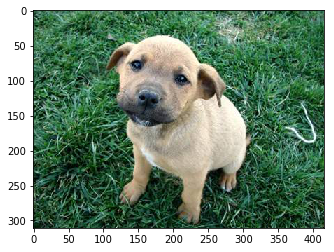

In [124]:
# Sample a random set of images
images = random.choices(get_files('dog'), k=5)
num_dogs = sum([1 for img in get_files('dog')])
num_cats = sum([1 for img in get_files('cat')])

print('num dogs', num_dogs)
print('num cats', num_cats)
print('files', images)

dog_img = plt.imread(get_path('dog', images[0]))
plt.imshow(dog_img)

In [125]:
# Plot image sizes
dog_sizes = np.array([Image.open(get_path('dog', f)).size for f in get_files('dog')])
cat_sizes = np.array([Image.open(get_path('cat', f)).size for f in get_files('cat')])
sizes = np.append(dog_sizes, cat_sizes, axis=0)
widths = sizes[:, 0] 
heights = sizes[:, 1]

(array([ 266., 1164., 2330., 2548., 6191.,    0.,    0.,    0.,    0.,    1.]),
 array([  50.,  150.,  250.,  350.,  450.,  550.,  650.,  750.,  850.,  950., 1050.]),
 <a list of 10 Patch objects>)

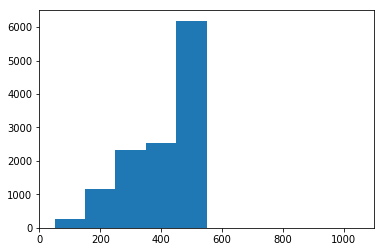

In [126]:
# Image widths
plt.hist(widths)

(array([  79.,  402.,  905., 1612., 2069., 4516., 2916.,    0.,    0.,    1.]),
 array([ 32.,  99., 166., 233., 300., 367., 434., 501., 568., 635., 702.]),
 <a list of 10 Patch objects>)

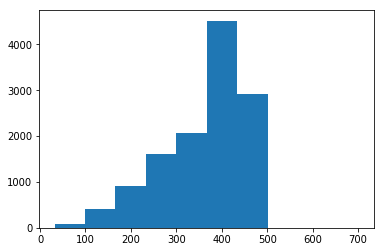

In [127]:
# Image heights
plt.hist(heights)

In [132]:
# Training imports and constants
from fastai.dataset import ImageClassifierData
from fastai.model import resnet34
from fastai.transforms import tfms_from_model, transforms_side_on
from fastai.conv_learner import ConvLearner
BATCH_SIZE=64
ARCH=resnet34

In [168]:
def get_data(size, batch_size):
    transforms = tfms_from_model(ARCH, size, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_paths(PATH, tfms=transforms, bs=batch_size, test_name='test')

In [134]:
IMG_SIZE=224
data = get_data(IMG_SIZE, BATCH_SIZE)

In [135]:
learn = ConvLearner.pretrained(ARCH, data)

In [136]:
# Find learning rate
learn.lr_find()

 89%|████████▉ | 175/196 [00:56<00:06,  3.27it/s, loss=0.676]

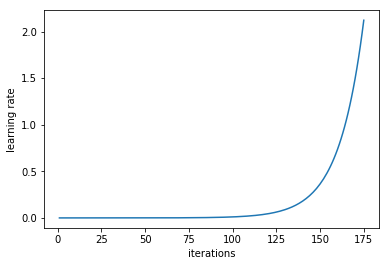

In [137]:
# Plot learning rate as a function of iterations
learn.sched.plot_lr()

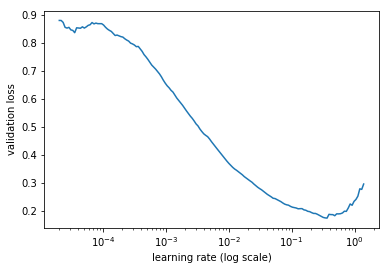

In [138]:
# Plot validation loss as a function of learning rate
learn.sched.plot()

In [139]:
LEARNING_RATE = 0.05

In [140]:
learn.fit(LEARNING_RATE, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.117659   0.05112    0.98888   
    1      0.066977   0.041871   0.99                         
    2      0.055371   0.040527   0.98872                      
    3      0.053745   0.031812   0.99008                      
    4      0.046181   0.032993   0.99                         


[array([0.03299]), 0.99]

In [141]:
learn.save('224_cats_dogs_redux_1')

In [142]:
learn.load('224_cats_dogs_redux_1')

In [186]:
# Starting training on small images for a few epochs, then switching to bigger images,
# and continuing training is an amazingly effective way to avoid overfitting. (apparently)
# So try setting a larger mage size and training again
IMG_SIZE=299
data = get_data(IMG_SIZE, BATCH_SIZE)
learn.set_data(data) 

In [145]:
learn.fit(LEARNING_RATE, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.039119   0.03037    0.99096   
    1      0.045341   0.030126   0.99032                      
    2      0.036136   0.027431   0.99112                      
    3      0.032282   0.027059   0.992                        
    4      0.032528   0.029614   0.99096                      
    5      0.030441   0.024716   0.99192                      
    6      0.031595   0.025198   0.99168                      


[array([0.0252]), 0.99168]

In [146]:
learn.save('299_cats_dogs_redux_1')

In [147]:
learn.load('299_cats_dogs_redux_1')

In [148]:
# Get training set predictions using test time augmentation (TTA)
log_preds, y = learn.TTA()

In [198]:
# Test time imports
import pandas as pd
from sklearn import metrics
from fastai.metrics import accuracy_np
from IPython.lib.display import FileLink

In [154]:
# Print acccuracy, loss loss of training predictions
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.99256, 0.022079569718665443)

In [171]:
# Get test set predictions using test time augmentation (TTA)
log_preds, y = learn.TTA(is_test=True)

In [202]:
probs = np.mean(np.exp(log_preds),0)

In [207]:
"""
Sample submission is a csv with format:

    id,label
    1,0.5
    2,0.5
    3,0.5
    4,0.5

"""
#preds = np.argmax(probs, axis=1) This wrong - submit probabilities, not best-guess predictions
preds = probs[:, 1]
ids = [f.replace('test/', '').replace('.jpg', '') for f in data.test_ds.fnames]
results = np.array(list(zip(ids, preds)))
df = pd.DataFrame(results)
df.columns = ('id', 'label')
# df.head(20)
SUBMISSION = f'{PATH}submission.csv'
df.to_csv(SUBMISSION, index=False)
FileLink(SUBMISSION)

/home/paperspace/data/cats-dogs-redux/submission.csv

In [208]:
# Ranked 256 / 1300
# Training loss of 0.03
# Validation loss of ~0.03
# Test loss of 0.08